## Subtask 3: Integration with Shape Detectors.
In this subtask, we have merged together the Viola Jones detector trained using dartboards, with the Hough Transform for circles.

#### Load folder path

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import cv2
import math
import time
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import library as lib
from os import listdir
from os.path import isfile, join

mypath = str(input("Enter folder path (eg.'../images/'): "))

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles = sorted(onlyfiles)

def imshow(image, s=""):
    #OpenCV stores images in BGR so we have to convert to RGB to display it using matplotlib
    imagergb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title(s + " Click to close.", fontsize=14)
    plt.imshow(imagergb)

pylab.rcParams['figure.figsize'] = (20,10)


Enter folder path (eg.'../images/'): ../images/


#### Load image and annotate the ground truth

In [2]:
# INTERACTIVE GROUND TRUTH MODE
%matplotlib

fname = str(input("File name: "))

i = 0
for a in range(len(onlyfiles)):
    if str(onlyfiles[a]) == fname:
        i = a

dart = bool(input("Detect faces(0) or dart(1)?"))

location = mypath + onlyfiles[i]


image = cv2.imread(location)
image = lib.imresize(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.waitforbuttonpress()
plt.close()

amount = int(input("How many objects do you want to annotate?: "))

store = np.zeros((amount,2,2), dtype=int)

for k in range(0,amount): 

    plt.imshow(img)

    lib.drawshow('You will annotate the image, click to continue.')

    plt.waitforbuttonpress()
    
    while True:

        pts = []
        while len(pts) < 2:
            lib.drawshow('For each object, draw the boundary by selecting 2 opposite corners with your right click, then press enter.')
            pts = plt.ginput(2, timeout=-1, show_clicks=True)
            
            if len(pts) < 2:
                lib.drawshow('Too few points, starting over.')
                time.sleep(1)  # Wait a second

        cv2.rectangle(img, (int(pts[0][0]),int(pts[0][1])), (int(pts[1][0]),int(pts[1][1])), (128,0,128), 5)
        
        store[k] = pts

        plt.imshow(img)
        lib.drawshow('Done? Enter to continue, mouse click to redo this object. ')

        if plt.waitforbuttonpress(timeout=-1):
            break

        image = cv2.imread('./images/dart'+str(i)+ '.jpg')
        # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    print(pts)
plt.close()
print(store)

ground = np.zeros((len(store),4),dtype=int)

for k in range (len(store)):
    s = store[k][1] - store[k][0]
    ground[k] = (store[k][0][0], store[k][0][1], s[0],s[1])
    (x,y,w,h) = ground[k]
    cv2.rectangle(image, (x,y), (x+w,y+h), (128,0,128),3)

Using matplotlib backend: Qt5Agg
File name: dart03.jpg
Detect faces(0) or dart(1)?
How many objects do you want to annotate?: 1
[(320.13771182161526, 147.073266546828), (398.1506786370705, 222.8140110278524)]
[[[320 147]
  [398 222]]]


### 1. We first run the Hough Transform to detect dartboards using circles 

0.0
EdgeDetect runtime: 2.252126932144165
Edge image saved


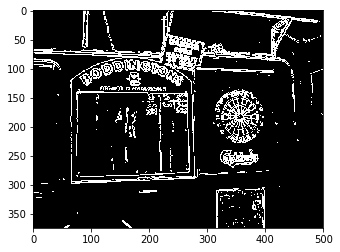

In [3]:
%matplotlib inline
# Setting the thresholds
edgethresh = 2.2
judgethresh = 0.5
# Setting the max and min radius of a detected circle in HT
minrad = 10
maxrad = 100
# Set the min proximity of any 2 HT circles`
proximity = 70

# Loading chosen image
imgcol = cv2.imread(location)
imgcol = lib.imresize(imgcol)

imggray = cv2.cvtColor(imgcol, cv2.COLOR_BGR2GRAY)

# Finding the edges of the image above a threshold
stime = time.time()
grad, direc = lib.EdgeDetect (imggray, threshavg=edgethresh)
print (np.min(direc))
print ("EdgeDetect runtime: " + str(time.time() - stime) )

# Saving the edge image
saveloc = str("detected/edge_") + onlyfiles[i]
cv2.imwrite(saveloc,grad)
plt.imshow(grad, cmap='gray')
print ("Edge image saved")

In [6]:
#Running the Hough Transform for circles
stime = time.time()
Hxyr = lib.HTCircle(grad, direc, minrad, maxrad)
etime = time.time()
print("runtime: Hough Transform " + str(etime-stime))

Performing Hough Transform - Circles:
progress - 0%
progress - 3%
progress - 7%
progress - 10%
progress - 13%
progress - 17%


KeyboardInterrupt: 

Hough Space Runtime: 20.523156881332397
Hough image saved


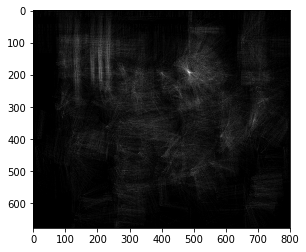

In [6]:
# Finding the Hough Space for the Hough Transform
stime = time.time()
Hspace = lib.HSpace(Hxyr)

#Saving the Hough Space image
saveloc = str("detected/HS_") + onlyfiles[i]
cv2.imwrite(saveloc,Hspace)
print ("Hough Space Runtime: " + str(time.time()-stime))
plt.imshow(Hspace, cmap='gray')
print ("Hough image saved")

Hough transform image saved


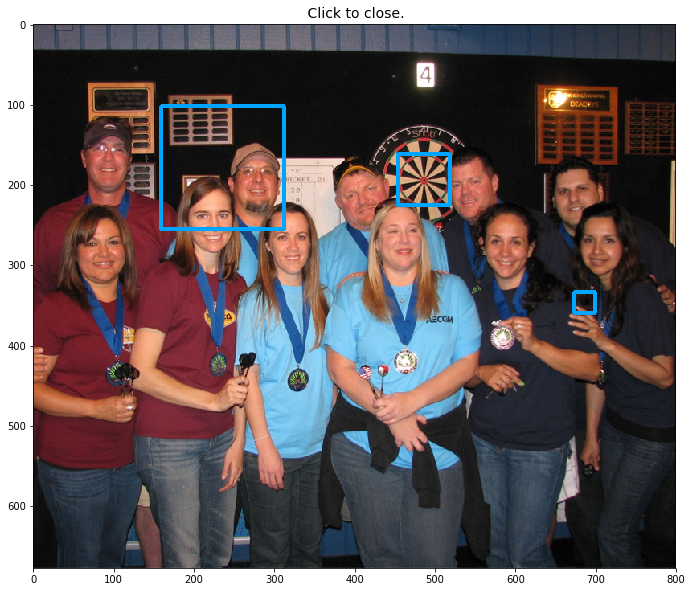

In [17]:
#Reloading a fresh coloured image
imgcol = cv2.imread(location)
imgcol = lib.imresize(imgcol)


# Finding the rectangle that encloses the 3 most likely circles
rect0, rect1, rect2 = lib.PlotRectangle(imgcol, Hxyr, Hspace, minrad, maxrad, prox=proximity)
dart_HT = np.array([rect0,rect1,rect2])

# Plotting the HT detection on the coloured image
for (x,y,w,h) in dart_HT:
        cv2.rectangle(imgcol, (x,y), (x+w,y+h), (255,165,0), 3)
#         cv2.circle(imgcol, (int(x+w/2), int(y+h/2)), int(w/2), (255,165,0), 2)
        
# Saving the HT detection image
saveloc = str("detected/HT_") + onlyfiles[i]
cv2.imwrite(saveloc,imgcol)
print ("Hough transform image saved")
imshow(imgcol)

### 2. Next we run Viola-Jones trained with dartboards

Viola-Jones image saved


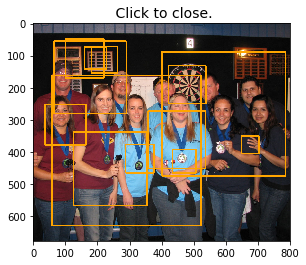

In [8]:
#Reloading a fresh coloured image
imgcol = cv2.imread(location)
imgcol = lib.imresize(imgcol)


# Finding the detected dartboards for Viola-Jones
classifier = cv2.CascadeClassifier('cascade.xml')
dart_VJ = lib.ViolaJones(i, imgcol, classifier)
for (x,y,w,h) in dart_VJ:
        cv2.rectangle(imgcol, (x,y), (x+w,y+h), (0,165,255), 3)

# Saving VJ detected image
saveloc = str("detected/VJ_") + onlyfiles[i]
cv2.imwrite(saveloc,imgcol)
print ("Viola-Jones image saved")
imshow(imgcol)

### 3. Finally, we compare each classification with all the ones from the other.
#### We calculate the harmonic mean of the ovelapping area with respect to each image and keep the Viola-jones classifications that have a higher threshold.

Joing HT & VJ image saved


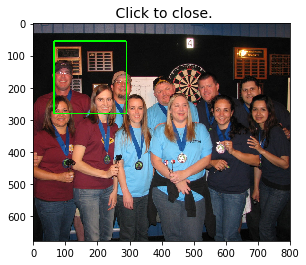

In [9]:
# Reload the coloured image
imgcol = cv2.imread(location)
imgcol = lib.imresize(imgcol)


# Combining Viola-Jones and Hough Transform by finding the overlapping classifications and plotting the corresponding VJ rectangle
judge, dart_VJHT = lib.Eval (dart_VJ,dart_HT, imgcol, thresh=judgethresh)

# Saving the detection of combined VJ and HT
saveloc = str("detected/VJHT_") + onlyfiles[i]
cv2.imwrite(saveloc,imgcol)
print ("Joing HT & VJ image saved")
imshow(imgcol)

### 4. To compare our results, we plot the F1-score with just Viola Jones, and combined with the Hough Transform

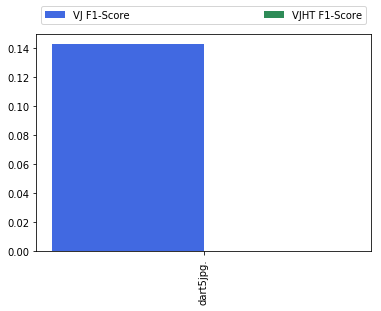

In [10]:
#Reload image
imgcol = cv2.imread(location)
# Finding the f1-score & re-drawing
judge,_ = lib.Eval (ground, dart_VJHT, imgcol, 0.5)
judge2,_ = lib.Eval (ground, dart_VJ, imgcol, 0.5)
# Get TP, FP and FN of the joint detector and calculate the f1 score & tru positive rate
detection = lib.getinfo(judge, dart_VJHT)
detection2 = lib.getinfo(judge2,dart_VJ)


f1 = []
f1_VJ = []
f1.append(lib.f1score(detection))
f1_VJ.append(lib.f1score(detection2))

lib.f1bar(f1_VJ, f1, [i])


In [45]:
def HTlines (grad,direc): 
    (M,N) = grad.shape
    ro = int(math.sqrt(M**2 + N**2))
    error = 1
    theta = np.arange(0,360,1)
    rothe = np.zeros((360, ro))
    for m in range (M):
        for n in range (N): 
            if grad[m,n] == 255:
                
                t0 = int(np.round(direc[m,n]*180/math.pi)) % 360
                t1 = (t0 - 1) % 360
                t2 = (t0 + 1) % 360
                
                ro0 = int(n*math.cos(t0) + m*math.sin(t0))
                ro1 = int(n*math.cos(t1) + m*math.sin(t1))
                ro2 = int(n*math.cos(t2) + m*math.sin(t2))
                rothe[t0, ro0] += 1
                rothe[t0, ro0-1] += 1
                rothe[t0, ro0+1] += 1
                
                rothe[t1, ro1] += 1
                rothe[t1, ro1-1] += 1
                rothe[t1, ro1+1] += 1
                
                rothe[t2, ro2] += 1
                rothe[t2, ro2-1] += 1
                rothe[t2, ro2+1] += 1
                
    return rothe
                

In [46]:
rothe = HTlines (grad,direc)

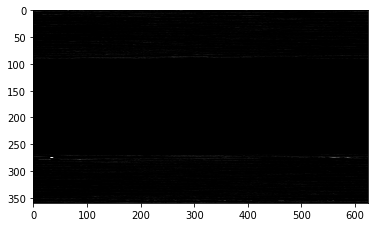

In [47]:
plt.imshow(rothe, cmap='gray')
